In [2]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
import scipy

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
import pandas as pd

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image, Markdown, display
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import fourier, pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import SplineTransformer
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

In [3]:
df = pd.read_csv("../DATA/global_economy.csv")
df = df[df.unique_id == "China"]
gdp = df[["unique_id", "ds"]]
gdp["y"] = df["GDP"]

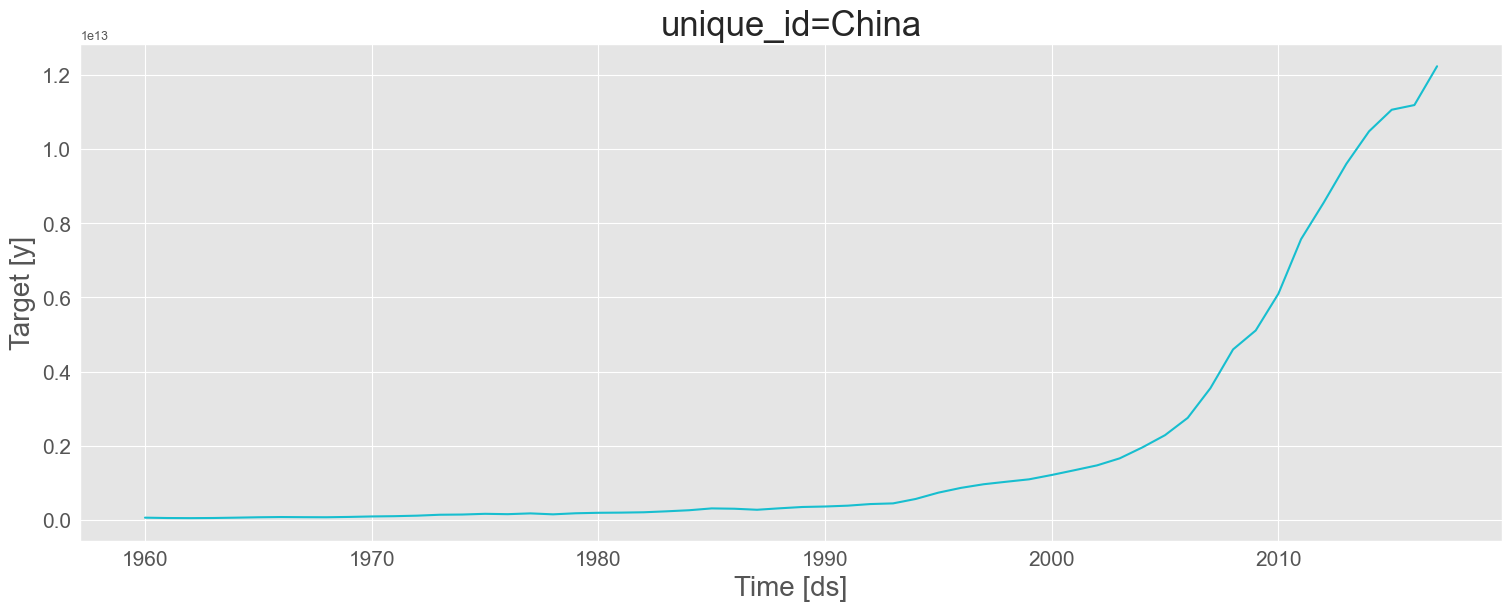

In [4]:
plot_series(gdp)

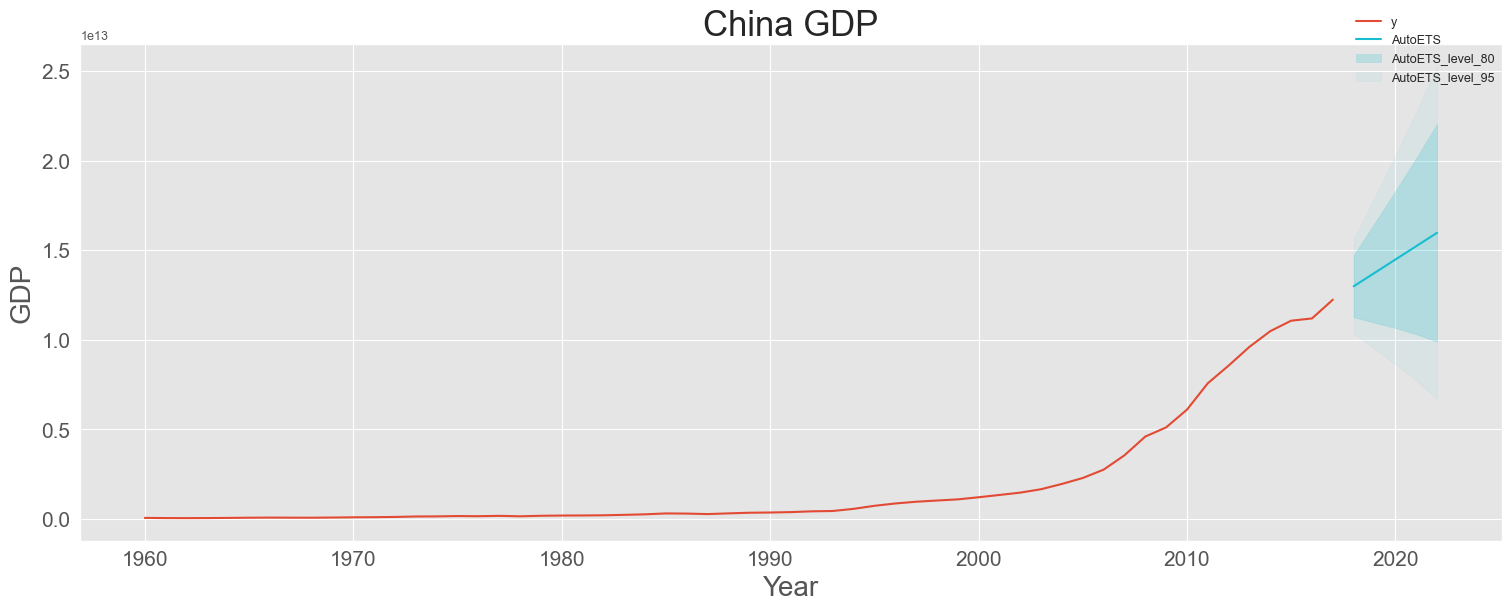

In [5]:
sf = StatsForecast(models=[AutoETS(model="MAN", season_length=1)], freq=1)
fc = sf.forecast(df=gdp, h=5, level=[80, 95], fitted=True)
plot_series(
    gdp,
    fc,
    level=[80, 95],
    xlabel="Year",
    ylabel="GDP",
    title="China GDP",
    rm_legend=False,
)

-0.17328992747599453


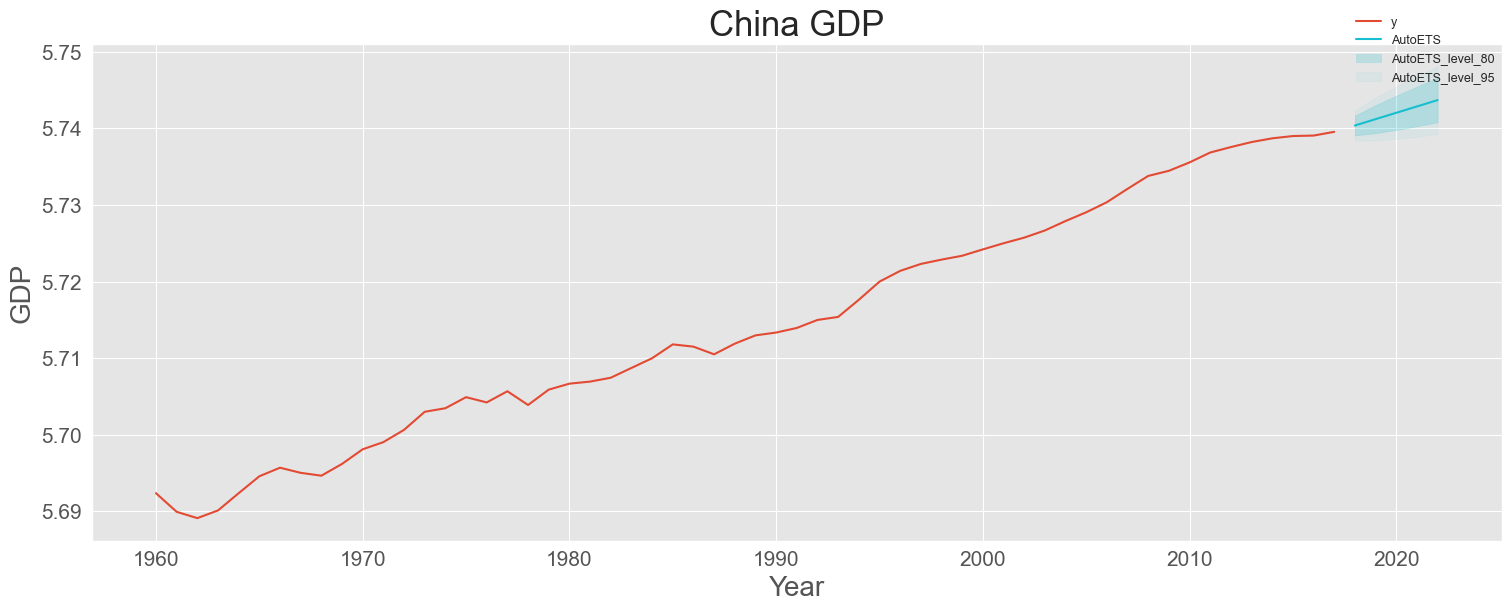

In [18]:
box_y, lbd = scipy.stats.boxcox(gdp.y)
box_gdp = gdp.copy()
box_gdp.y = box_y
print(lbd)

sf = StatsForecast(models=[AutoETS(model="ZZZ", season_length=1)], freq=1)
fc = sf.forecast(df=box_gdp, h=5, level=[80, 95], fitted=True)
plot_series(
    box_gdp,
    fc,
    level=[80, 95],
    xlabel="Year",
    ylabel="GDP",
    title="China GDP",
    rm_legend=False,
)

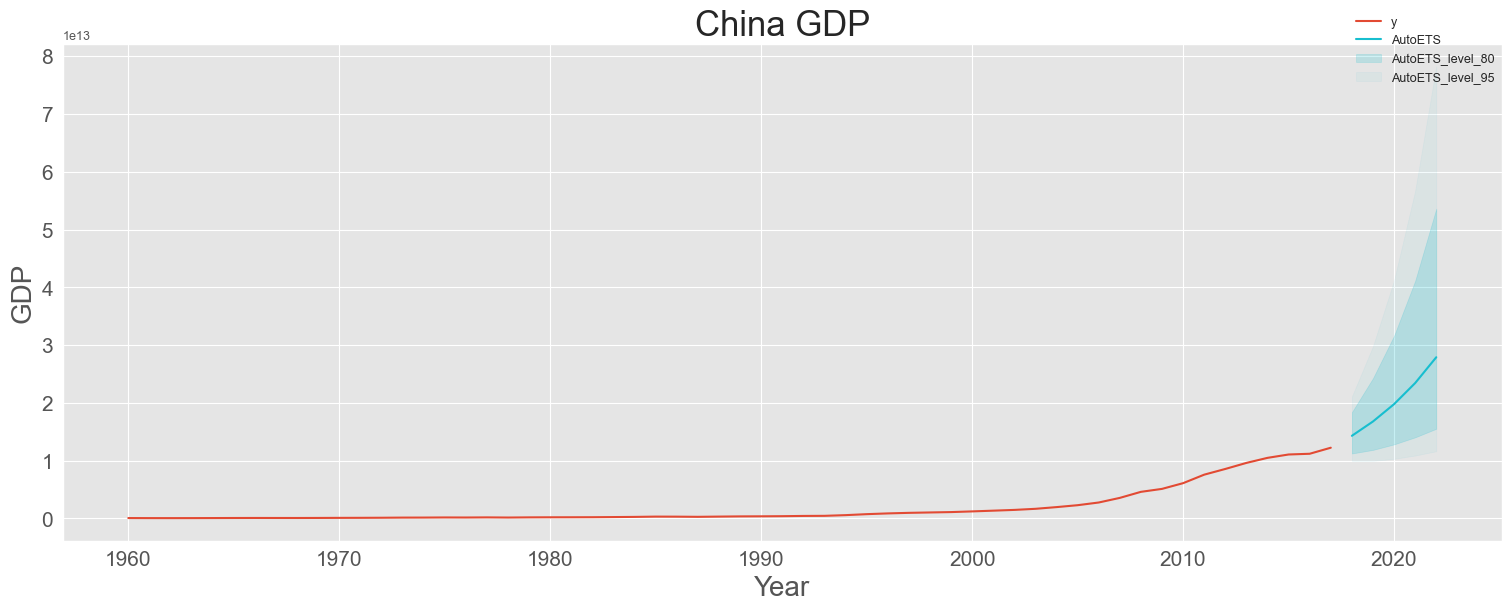

In [26]:
scipy.special.inv_boxcox(box_y, lbd)
inv_box = fc.copy()
inv_box.AutoETS = scipy.special.inv_boxcox(inv_box.AutoETS, lbd)
inv_box["AutoETS-lo-95"] = scipy.special.inv_boxcox(inv_box["AutoETS-lo-95"], lbd)
inv_box["AutoETS-lo-80"] = scipy.special.inv_boxcox(inv_box["AutoETS-lo-80"], lbd)
inv_box["AutoETS-hi-80"] = scipy.special.inv_boxcox(inv_box["AutoETS-hi-80"], lbd)
inv_box["AutoETS-hi-95"] = scipy.special.inv_boxcox(inv_box["AutoETS-hi-95"], lbd)
plot_series(
    gdp,
    inv_box,
    level=[80, 95],
    xlabel="Year",
    ylabel="GDP",
    title="China GDP",
    rm_legend=False,
)

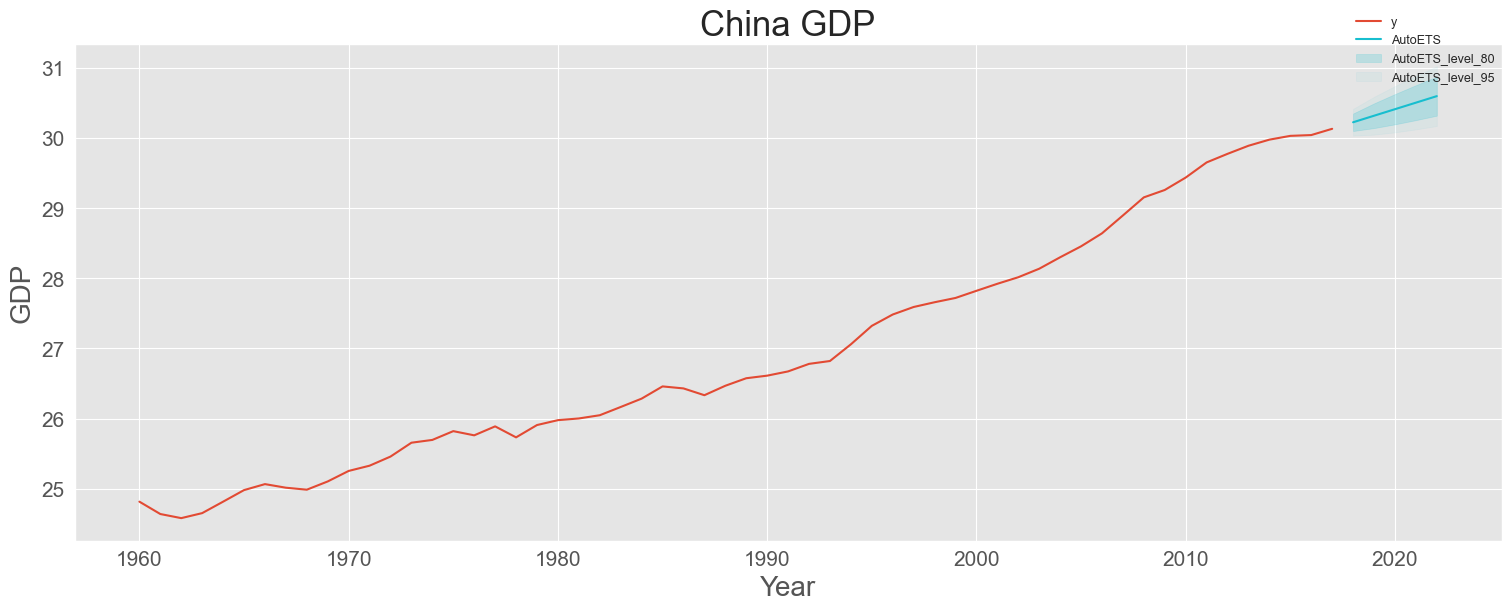

In [29]:
log_gdp = gdp.copy()
log_gdp.y = np.log(log_gdp.y)
sf = StatsForecast(models=[AutoETS(model="ZZZ", season_length=1)], freq=1)
fc = sf.forecast(df=log_gdp, h=5, level=[80, 95], fitted=True)
plot_series(
    log_gdp,
    fc,
    level=[80, 95],
    xlabel="Year",
    ylabel="GDP",
    title="China GDP",
    rm_legend=False,
)

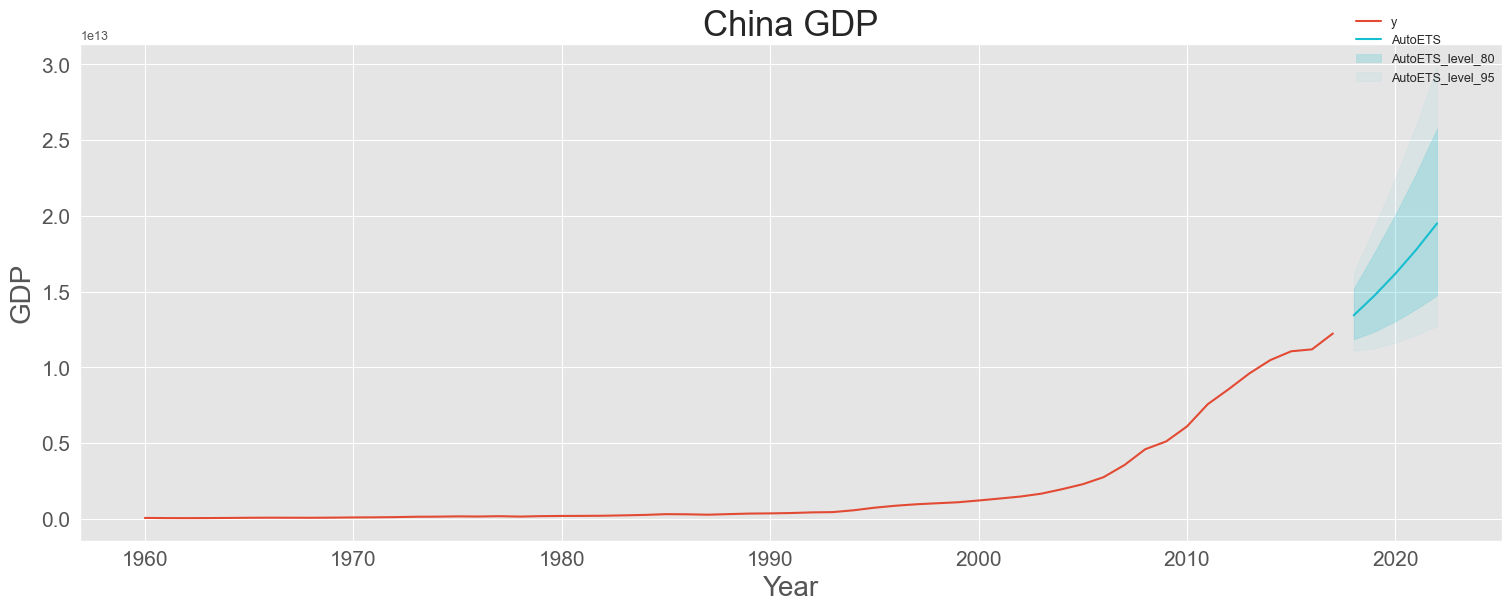

In [30]:
exp_fc = fc.copy()
exp_fc.AutoETS = np.exp(exp_fc.AutoETS)
exp_fc["AutoETS-lo-95"] = np.exp(exp_fc["AutoETS-lo-95"])
exp_fc["AutoETS-lo-80"] = np.exp(exp_fc["AutoETS-lo-80"])
exp_fc["AutoETS-hi-80"] = np.exp(exp_fc["AutoETS-hi-80"])
exp_fc["AutoETS-hi-95"] = np.exp(exp_fc["AutoETS-hi-95"])

plot_series(
    gdp,
    exp_fc,
    level=[80, 95],
    xlabel="Year",
    ylabel="GDP",
    title="China GDP",
    rm_legend=False,
)